# Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max, min
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

In [2]:
spark = SparkSession.builder.appName("Jupyter").getOrCreate()
spark

24/07/15 12:20:27 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Test Spark can connect

In [3]:
%%sql

SELECT * FROM demo.silver.dfo LIMIT 10;

timestamp,sensor_name,distance,measurement,value
2024-07-15 12:14:18,sensor1,0,RMS0,1.0
2024-07-15 12:14:18,sensor1,1,RMS0,1.0
2024-07-15 12:14:18,sensor1,2,RMS0,1.0
2024-07-15 12:14:18,sensor1,3,RMS0,1.0
2024-07-15 12:14:18,sensor1,4,RMS0,1.0
2024-07-15 12:14:18,sensor1,5,RMS0,1.0
2024-07-15 12:14:18,sensor1,6,RMS0,1.0
2024-07-15 12:14:18,sensor1,7,RMS0,1.0
2024-07-15 12:14:18,sensor1,8,RMS0,1.0
2024-07-15 12:14:18,sensor1,9,RMS0,1.0


# Get data and plot it

In [15]:
# Get the current timestamp and calculate the timestamp for one minute ago
current_time = datetime.now()
delta = timedelta(minutes=10)
t_min = current_time - delta

# Query the last minute of data
query = """
SELECT timestamp, sensor_name, distance, value
FROM demo.silver.dfo
WHERE timestamp >= '{}' AND measurement = 'RMS0'
ORDER BY timestamp, sensor_name
""".format(t_min.strftime('%Y-%m-%d %H:%M:%S'))

In [16]:
df = spark.sql(query)

# Convert to Pandas DataFrame
pdf = df.toPandas()
pdf['timestamp'] = pd.to_datetime(pdf['timestamp'])
pdf['distance'] = pd.to_numeric(pdf['distance'])
pdf['value'] = pd.to_numeric(pdf['value'])

In [17]:
# Group by timestamp and distance, and aggregate the values (using mean as an example)
grouped_df = pdf.groupby(['timestamp', 'distance'])['value'].mean().reset_index()

# Create a pivot table from the grouped data
pivot_df = grouped_df.pivot(index='distance', columns='timestamp', values='value')

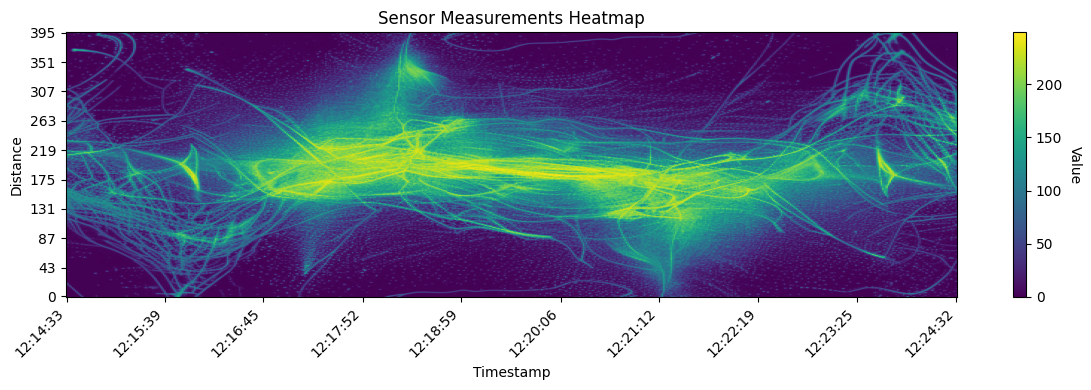

In [18]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(pivot_df, aspect='auto', cmap='viridis', origin='lower')

# Set x-axis (timestamp) ticks and labels
num_xticks = 10  # Adjust this number to control the density of x-axis ticks
x_tick_locs = np.linspace(0, len(pivot_df.columns) - 1, num_xticks, dtype=int)
ax.set_xticks(x_tick_locs)
ax.set_xticklabels(pivot_df.columns[x_tick_locs].strftime('%H:%M:%S'), rotation=45, ha='right')

# Set y-axis (distance) ticks and labels
num_yticks = 10  # Adjust this number to control the density of y-axis ticks
y_tick_locs = np.linspace(0, len(pivot_df.index) - 1, num_yticks, dtype=int)
ax.set_yticks(y_tick_locs)
ax.set_yticklabels(pivot_df.index[y_tick_locs])

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Value', rotation=-90, va="bottom")

# Set labels and title
ax.set_title('Sensor Measurements Heatmap')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Distance')

plt.tight_layout()
plt.show()